In [1]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 33.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from pyvi import ViTokenizer

import string
import nltk
import re

from tensorflow.keras.models import Model, load_model

from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

import re
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

In [3]:
import os
# dir = '/content/drive/MyDrive/NLP/dữ liệu chatbot - dự án cuối kì'
dir = '../input/chatbot-data/chatbot'

filenames = os.listdir(dir)
print(filenames)

['shoping.txt', 'a ch.txt', 'tn gu.txt', 'bn b.txt', 'tdtu.txt', 's thch.txt', 'thng tin c nhn.txt', 'hc tp.txt', 'ngh nghip.txt', 'ngi yu.txt', 'gii tr.txt', 'tr chuyn v i n.txt', 'gia nh.txt', 'cc cu hi phc tp.txt', 'du lch.txt', 't nc.txt', 'robot.txt', 'ngh l.txt']


In [4]:
Q = []
A = []
for i in filenames:
    with open(dir+'/'+i, encoding="utf8") as f:
        for line in f:
            a =  line.split('__eou__')
            Q.append(a[0].strip())
            A.append(a[1].strip())
print('Number of QA pairs:', len(Q), '\n')

# shuffle to mix the data topic
QA = pd.DataFrame(zip(Q, A))
QA = QA.sample(frac=1, random_state=61)

Q = QA.iloc[:, 0].values
A = QA.iloc[:, 1].values

for i in range(5):
    print('Q:', Q[i])
    print('A:', A[i], '\n')

Number of QA pairs: 5855 

Q: có loại nào đặc biệt không bạn ?
A: có 2 loại đặc biệt nha bạn 

Q: Ê mày tao định mua son nè mày thấy chỗ nào bán được không?
A: à mày qua moon shop quận 7 thử 

Q: cho tôi hỏi nhà này có bao nhiêu phòng?
A: ngồi nhà này có đến 5 phòng nha bạn 

Q: Đặc sản của quê bạn là gì?
A: Về trái cây thì có thanh long, Về thức ăn thì có bánh căn 1 loại bánh như bánh xèo nhưng nhỏ hơn. 

Q: vậy còn số điện thoại của cậu là bao nhiêu?
A: số điện thoại của tớ là 0234567891 



In [5]:
stop_words = np.loadtxt('../input/chatbot-data/vietnamese-stopwords-dash.txt', dtype=str, encoding='utf8')
def remove_stop_word(sent):
    clean_sent = ''
    for w in sent.split():
        if w not in stop_words:
            clean_sent += w + ' '
    return clean_sent.strip()

def normalize(data, keep_stop_word=False):
    cleaned_data = []
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    for sent in data:
        sent = regex.sub('', sent)
        sent = ViTokenizer.tokenize(sent)
        if keep_stop_word == False:
            sent = remove_stop_word(sent.lower())
        cleaned_data.append(sent)
    return cleaned_data

In [6]:
questions = normalize(Q, keep_stop_word=False)  # only remove stop words from questions
answers = normalize(A, keep_stop_word=True)  # keep stop words in answers for a natural prediction output

for i in range(5):
    print('Q:', questions[i])
    print('A:', answers[i], '\n')

Q: 
A: có 2 loại đặc_biệt nha bạn 

Q: ê mày tao định mua son nè mày chỗ
A: à mày qua moon shop quận 7 thử 

Q: phòng
A: ngồi nhà này có đến 5 phòng nha bạn 

Q: đặc_sản quê
A: Về trái_cây thì có thanh_long Về thức_ăn thì có bánh căn 1 loại bánh như bánh_xèo nhưng nhỏ hơn 

Q: điện_thoại
A: số điện_thoại của tớ là 0234567891 



In [7]:
# start and end of string token to each answer
for i in range(len(answers)):
    answers[i] = '<start> ' + answers[i] + ' <end>'

In [8]:
# count each token appearing time 
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(questions + answers + ['<unk>'])
VOCAB_SIZE = len(tokenizer.word_index) + 1 # padding token for embedding layer later
print('VOCAB SIZE: {}'.format(VOCAB_SIZE))
vocab = list(tokenizer.word_index.keys()) # list of tokens

VOCAB SIZE: 5133


In [9]:
tokenized_questions = tokenizer.texts_to_sequences(questions)
tokenized_answers = tokenizer.texts_to_sequences(answers)

# due to stop words cleaning, there are empty questions
# => remove pair with empty question from the training data

indices = []
for i in range(len(tokenized_questions)):
    if len(tokenized_questions[i])==0:
        indices.append(i)
tokenized_questions = np.delete(tokenized_questions, indices)
tokenized_answers = np.delete(tokenized_answers, indices)
print('Number of removed pair:', len(indices))
print('Number of train data after cleaning:', len(tokenized_questions))

Number of removed pair: 476
Number of train data after cleaning: 5379


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [10]:
MAXLEN_QUESTION = max([len(x) for x in tokenized_questions])
padded_questions = pad_sequences(tokenized_questions, maxlen=MAXLEN_QUESTION, padding='post')
encoder_input_data = np.array(padded_questions)
print('Encoder input data shape:', encoder_input_data.shape)
print('Max length of encoder input data:', MAXLEN_QUESTION)

Encoder input data shape: (5379, 18)
Max length of encoder input data: 18


In [11]:
MAXLEN_ANSWER = max([len(x) for x in tokenized_answers])
padded_answers = pad_sequences(tokenized_answers, maxlen=MAXLEN_ANSWER, padding='post')
decoder_input_data = np.array(padded_answers)
print('Decoder input data shape:', decoder_input_data.shape)
print('Max length of decoder input data:', MAXLEN_ANSWER)

Decoder input data shape: (5379, 113)
Max length of decoder input data: 113


In [12]:
padded_answers_dec_out = pad_sequences(padded_answers[:, 1:], maxlen=MAXLEN_ANSWER, padding='post')
decoder_output_data = to_categorical(padded_answers_dec_out, VOCAB_SIZE, dtype='uint8')# remove <start> tag in answers data
print('Decoder ouput data shape:', decoder_output_data.shape)

Decoder ouput data shape: (5379, 113, 5133)


In [13]:
encoder_inputs = Input(shape=(MAXLEN_QUESTION,))
encoder_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True) (encoder_inputs) # mask zero to acknowledge 0 padding
_, state_h, state_c = LSTM(200, return_state=True) (encoder_embedding) # return last hidden and cell state
encoder_states = [state_h, state_c]

2022-06-01 20:54:25.558127: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
decoder_inputs = Input(shape=(MAXLEN_ANSWER,))
decoder_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True) (decoder_inputs)
decoder_lstm = LSTM(200, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states) # passing all time steps hidden states to dense
decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
output = decoder_dense(decoder_outputs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 113)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 200)      1026600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 113, 200)     1026600     input_2[0][0]                    
______________________________________________________________________________________________

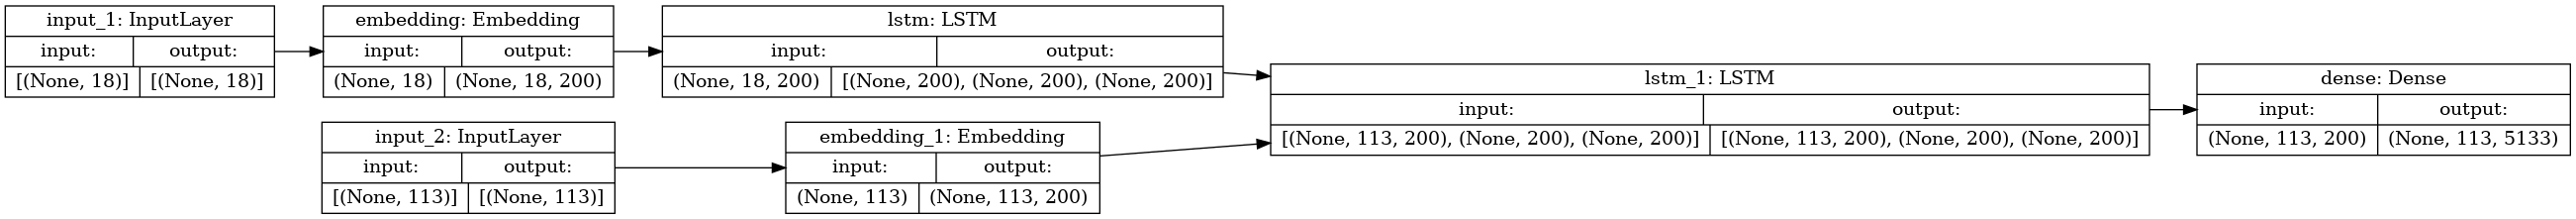

In [15]:
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
plot_model(model, rankdir='LR', show_shapes=True)

In [16]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=100, validation_split=0.1) # epochs >= 10

2022-06-01 20:54:32.089896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
152/152 [==============================] - 119s 723ms/step - loss: 0.5097 - accuracy: 0.1733 - val_loss: 0.4570 - val_accuracy: 0.2302
Epoch 2/100
152/152 [==============================] - 108s 708ms/step - loss: 0.4274 - accuracy: 0.2448 - val_loss: 0.4446 - val_accuracy: 0.2390
Epoch 3/100
152/152 [==============================] - 109s 715ms/step - loss: 0.4132 - accuracy: 0.2518 - val_loss: 0.4396 - val_accuracy: 0.2444
Epoch 4/100
152/152 [==============================] - 109s 719ms/step - loss: 0.4023 - accuracy: 0.2577 - val_loss: 0.4349 - val_accuracy: 0.2479
Epoch 5/100
152/152 [==============================] - 108s 710ms/step - loss: 0.3922 - accuracy: 0.2621 - val_loss: 0.4312 - val_accuracy: 0.2530
Epoch 6/100
152/152 [==============================] - 109s 716ms/step - loss: 0.3819 - accuracy: 0.2671 - val_loss: 0.4270 - val_accuracy: 0.2567
Epoch 7/100
152/152 [==============================] - 108s 711ms/step - loss: 0.3716 - accuracy: 0.2727 - val_loss: 0

In [17]:
def make_inference_models():
    
    # encoder model takes questions as input and output its LSTM state
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # decoder takes encoder output states as its initial state 
    # and 200 is the output of encoder last hidden and cell states dimension
    decoder_state_input_h = Input(shape=(200,))
    decoder_state_input_c = Input(shape=(200,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    # use these pre-trained layers of the model: decoder_embedding, decoder_lstm, decoder_dense 
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # decoder model takes one token and the states predicted from enc_model   
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

enc_model, dec_model = make_inference_models()
enc_model.save('enc_model.h5')
dec_model.save('dec_model.h5')

In [18]:
# # load model
# enc_model = load_model('./../input/chatbot-data/enc_model.h5')
# dec_model = load_model('../input/chatbot-data/dec_model.h5')

In [19]:
def format_question(sent:str):
    sent = normalize([sent], keep_stop_word=False)[0]
    words = sent.split()
    token_list = []
    for word in words:
        try:
            index = tokenizer.word_index[word]
        except KeyError:
            index = tokenizer.word_index['<unk>']
        token_list.append(index)
    return pad_sequences([token_list], maxlen=MAXLEN_QUESTION, padding='post', truncating='post')

In [20]:
def ask(question):
    print('Q:', question)
    question = format_question(question)
    states_values = enc_model.predict(question)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    
    stop_condition = False
    decoded_seq = ''
    while not stop_condition:
        # dec_outputs return a one hot vector with the dimension number of vocab size
        dec_outputs, h, c = dec_model.predict([target_seq] + states_values)
        gen_word_index = np.argmax(dec_outputs[0, -1])
        gen_word = tokenizer.index_word[gen_word_index]
        
        if gen_word == '<end>' or len(decoded_seq.split()) > MAXLEN_ANSWER:
            stop_condition = True
        else:
            decoded_seq += gen_word + ' '
            
        target_seq = np.zeros((1, 1))  
        target_seq[0, 0] = gen_word_index
        states_values = [h, c]
        
    answer = decoded_seq[0].upper() + decoded_seq[1:].replace('_', ' ')
    print('A:', answer.strip(), '\n')

In [21]:
ask('Bạn sinh năm bao nhiêu?')
ask('Có người yêu chưa?')
ask('Shop tư vấn cho mình một số mẫu giày thích hợp để đi chơi được không?')
ask('Quê bạn ở đâu?')
ask('Bạn thường làm gì trong thời gian rảnh?')
ask('Bạn có muốn đi xem phim vào cuối tuần này hay không?')
ask('Bạn thích môn thể thao gì?')

Q: Bạn sinh năm bao nhiêu?
A: Mình sinh năm 2001 

Q: Có người yêu chưa?
A: Mình chưa có người yêu 

Q: Shop tư vấn cho mình một số mẫu giày thích hợp để đi chơi được không?
A: Bạn có thể tham khảo vài đôi giày của adidas hoặc nike 

Q: Quê bạn ở đâu?
A: Quê mình ở thành phố hồ chí minh 

Q: Bạn thường làm gì trong thời gian rảnh?
A: Mình thường chơi game 

Q: Bạn có muốn đi xem phim vào cuối tuần này hay không?
A: Dĩ nhiên là muốn rồi 

Q: Bạn thích môn thể thao gì?
A: Đá banh 



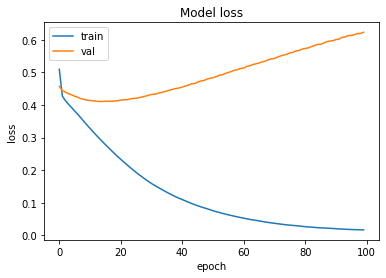

In [22]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()